In [190]:
import warnings

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import make_scorer, precision_score, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, TargetEncoder

from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import shap

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [191]:
random_state = 42

In [192]:
df = pd.read_csv('/Users/maiiayakusheva/Downloads/sp_sales_task/sales_df_train.csv')

In [193]:
df.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


In [195]:
df.date = pd.to_datetime(df.date)

- тренировочный датасет содержит 883015 строк и 8 столбцов с данными. Данные не содержат пропусков и дубликатов. Привела столбец с датами к временному типу.

***1) Предварительный анализ и предобработка тренировочного датасета:***

In [196]:
sns.set_palette("Set2")

распределения категориальных признаков


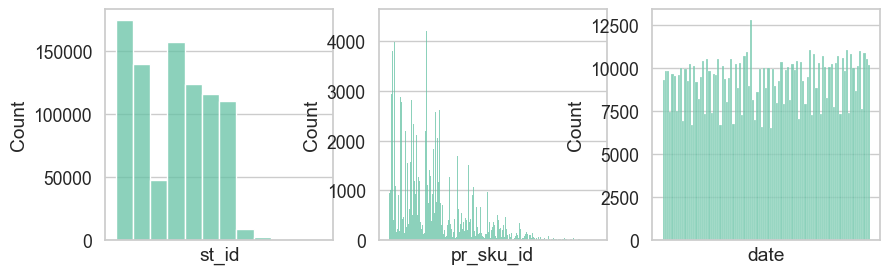

In [197]:
print('распределения категориальных признаков')
fig, axs = plt.subplots(ncols=3, figsize=(10, 3))
sns.histplot(data=df.st_id, ax=axs[0]).set_xticks([])
sns.histplot(data=df.pr_sku_id, ax=axs[1]).set_xticks([])
sns.histplot(data=df.date, ax=axs[2]).set_xticks([]);

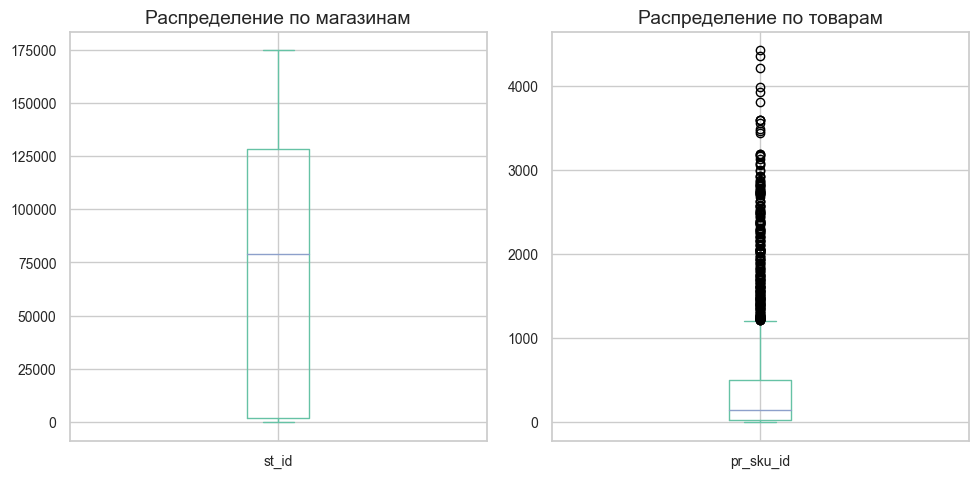

In [198]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
font_size=10
df.st_id.value_counts().plot.box(fontsize=font_size, ax=axs[0]).set_title('Распределение по магазинам')
df.pr_sku_id.value_counts().plot.box(fontsize=font_size, ax=axs[1]).set_title('Распределение по товарам')
fig.tight_layout()

- уже видим, что распределение продаж в некоторых магазинах и некоторых товаров значительно отличаются, то же самое видно и во временных рядах, посмотрим на цифры:

In [199]:
df.st_id.value_counts().to_frame(name='Итого:')

,Итого:
c81e728d9d4c2f636f067f89cc14862c,174687
16a5cdae362b8d27a1d8f8c7b78b4330,157542
42a0e188f5033bc65bf8d78622277c4e,140286
f7e6c85504ce6e82442c770f7c8606f0,124145
6364d3f0f495b6ab9dcf8d3b5c6e0b01,115830
fa7cdfad1a5aaf8370ebeda47a1ff1c3,110537
1ecfb463472ec9115b10c292ef8bc986,47404
53e19f3dbb211f20b20b45668303c1b6,9231
bd470ca955d9497bbcb808e59952fffc,2586
1aa057313c28fa4a40c5bc084b11d276,719


In [200]:
df.pr_sku_id.value_counts().to_frame(name='Итого:')

,Итого:
62d4af457ba2540ce0898a211c0cd17a,4424
ced0c1a84924c982a6403870c54b99ca,4362
cf91eca9321c9c272fb4e7cf4bcc6a43,4213
5b26f85ccb23039364226f66f0366c66,3982
6b1344097385a42484abd4746371e416,3929
...,...
8878e97692da06941dedcf44c1f50668,1
e18fadbb06e89f6f03545537c02b8bee,1
a4f2ee628051a3b73d6e1003ff6eaa5b,1
e65002dccbd12e07c33815a27e72a6cd,1


In [201]:
df.date.value_counts().to_frame(name='Итого:')

,Итого:
2022-12-30,3396
2022-12-29,3322
2022-12-24,3233
2022-12-28,3126
2023-06-23,3033
...,...
2023-01-03,2083
2023-04-17,2070
2023-01-09,2041
2023-01-02,1950


- теперь посмотрим на распределение численных признаков тренировочного датасета:

In [202]:
df.pr_sales_type_id.value_counts().to_frame(name='Итого:')

,Итого:
0,524082
1,358933


распределения численных признаков


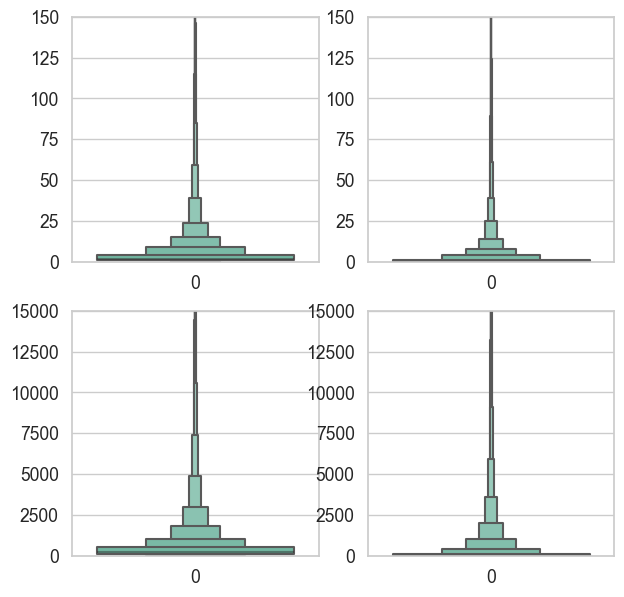

In [203]:
print('распределения численных признаков')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
sns.boxenplot(data=df.pr_sales_in_units, ax=axs[0,0]).set_ylim(0, 150)
sns.boxenplot(data=df.pr_promo_sales_in_units, ax=axs[0,1]).set_ylim(0, 150)
sns.boxenplot(data=df.pr_sales_in_rub, ax=axs[1,0]).set_ylim(0, 15000)
sns.boxenplot(data=df.pr_promo_sales_in_rub, ax=axs[1,1]).set_ylim(0, 15000);

распределения численных признаков


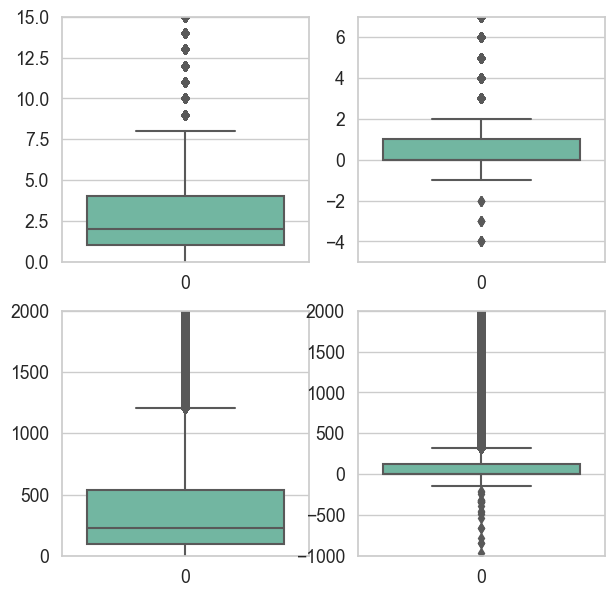

In [204]:
print('распределения численных признаков')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
sns.boxplot(data=df.pr_sales_in_units, ax=axs[0,0]).set_ylim(0, 15)
sns.boxplot(data=df.pr_promo_sales_in_units, ax=axs[0,1]).set_ylim(-5, 7)
sns.boxplot(data=df.pr_sales_in_rub, ax=axs[1,0]).set_ylim(0, 2000)
sns.boxplot(data=df.pr_promo_sales_in_rub, ax=axs[1,1]).set_ylim(-1000, 2000);

In [205]:
df[['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']].describe()

,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
count,883015.000000,883015.000000,883015.000000,883015.000000
mean,5.037956,2.230010,596.705181,294.766561
std,13.402984,11.063288,1577.366179,1402.764168
min,-39.000000,-39.000000,-3373.000000,-3373.000000
25%,1.000000,0.000000,98.000000,0.000000
50%,2.000000,0.000000,224.000000,0.000000
75%,4.000000,1.000000,540.000000,127.000000
max,2348.000000,2348.000000,183265.000000,183265.000000


In [206]:
df[(df.pr_sales_in_units==0)&(df.pr_sales_in_rub!=0)].pr_sales_in_rub.count()

66089

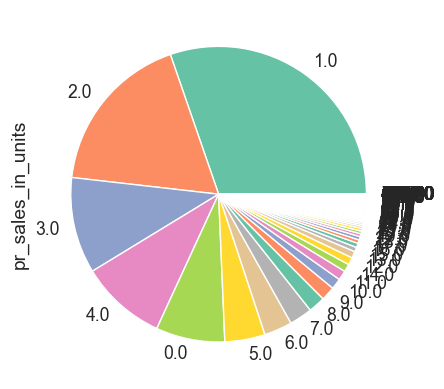

In [207]:
df.pr_sales_in_units.value_counts(vars).plot(kind='pie');

In [208]:
df[df.pr_sales_in_units<0].pr_sales_in_units.count()

71

In [209]:
df[(df.pr_promo_sales_in_units==0)&(df.pr_promo_sales_in_rub>0)].pr_sales_in_rub.to_frame(name='Продажи при нулевом количестве')

,Продажи при нулевом количестве
3,69.0
38,136.0
75,48.0
97,32.0
115,84.0
...,...
882924,61.0
882978,30.0
882991,70.0
883004,41.0


In [210]:
df[df.pr_promo_sales_in_units<0].pr_promo_sales_in_units.count()

35

In [211]:
df[(df.pr_sales_in_rub==0)&(df.pr_sales_in_units>0)].pr_sales_in_rub.count()

794

In [212]:
df[df.pr_sales_in_rub<0].pr_sales_in_rub.count()

78

In [213]:
df[(df.pr_promo_sales_in_rub==0)&(df.pr_promo_sales_in_units>0)].pr_promo_sales_in_rub.count()

677

In [214]:
df[df.pr_promo_sales_in_rub<0].pr_promo_sales_in_rub.count()

36

- в бинарном столбце с флагом наличия промо: примерно 60% товаров проданы без него, 40% с ним соответственно
- в распределении данных по количеству проданных единиц товаров(с промо и без) и по продажам(с промо и без) присутствуют выбросы:
  - количество проданных без промо: медиана - 2, мин 1 максимум 4, максимальное значение выброса достигает 2348, 66089(7%) строки содержат нулевые данные, несмотря на то, что продажи в этих строчках присутствуют(****в анализе нужно посмотрет на корреляции выбросов, чтобы понять это действительно выброс или нет****), есть отрицательные значения в количествах(несмотря на то, что возможно это были возвраты в день без покупок, такиx значений крайне мало - 71 штука, поэтому их удалю)
  - количество проданных с промо: среднее - 2, из-за большой дисперсии, в основном данные распределены вокруг значения 1. Также присутствуют нулевые значения при ненулевых продажах, здесь это 31006(3.5%), также есть отрицательные значения - 35 шт(также удалю)(****также в анализе нужно внимательно посмотреть на выбросы и вообще на соотношение проданных количеств с промо и без него****)
  - продажи в рублях: медиана в районе 250, распределение смещено вправо, поэтому среднее больше медианы почти в два раза(****также в анализе нужно внимательно посмотреть на выбросы и вообще на соотношение цен с промо и без него****), есть нулевые продажи при ненулевом количестве проданных единиц - 794 строки, есть отрицательные значения - 78 строк
  - продажи промо в рублях: данные очень разреженные, среднее опять вдвое больше медианы(****выбросы изучу в анализе****), 677 строк с нулевыми данными, при наличии в строке проданных единиц с промо, 36 отрицательных значений.

In [215]:
df = df[((df.pr_sales_in_units!=0)&(df.pr_sales_in_rub!=0))|\
    ((df.pr_sales_in_units==0)&(df.pr_sales_in_rub==0))]

In [216]:
df = df[(df.pr_sales_in_units>=0) & (df.pr_promo_sales_in_units>=0) & (df.pr_sales_in_rub>=0)\
     & (df.pr_promo_sales_in_rub>=0)]

In [217]:
df.shape[0]*100/883015

92.41756935046403

- Итак, я удалила данные, где не совпадало присутствие нулевых значений в столбцах с количеством и продажами, и с отрицательными значениями в этих данные(7,5% от датасета)

- теперь проверим данные на гетероскедастичность, подгоним простую модель линейной регрессии, используя количество проданных единиц в качестве зависимой переменной, предиктором выступят продажи. Построю график несвязок по сравнению с подобранным. Далее проведу тест Бреуша-Пагана, для проверки данных на гетероскедастичность:

In [218]:
import statsmodels.formula.api as smf
res = smf.ols('pr_sales_in_units ~ pr_sales_in_rub', data=df).fit()

eval_env: 1


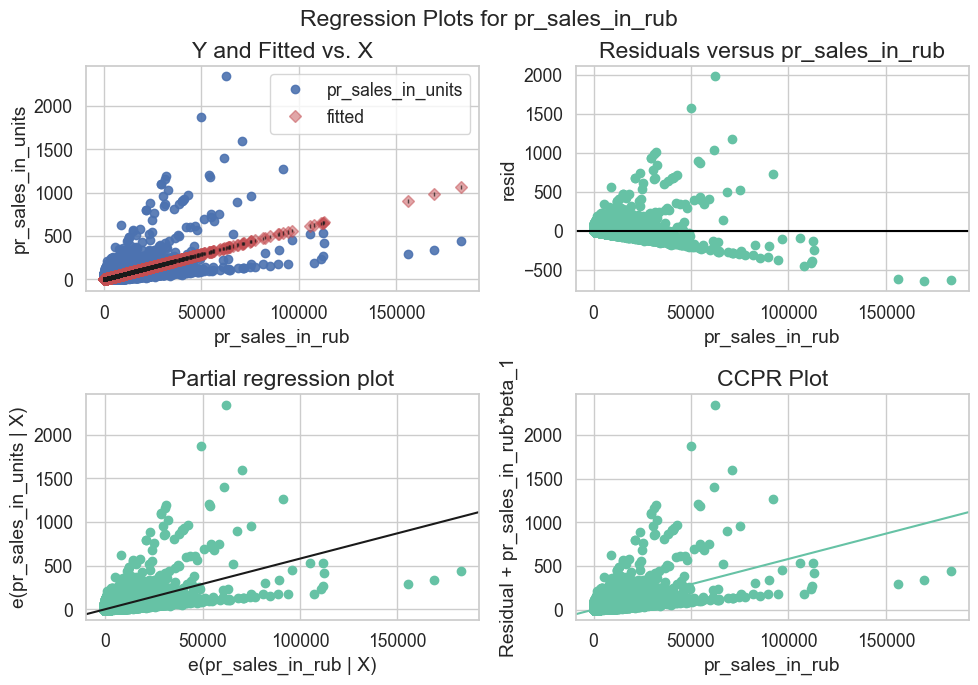

In [219]:
import statsmodels.api as sm

fig = plt.figure(figsize=(10, 7))
fig = sm.graphics.plot_regress_exog(res, 'pr_sales_in_rub', fig=fig)


- визуально заметно, что остатки становятся более разбросанными при более высоких значениях на графике, это указаывает на наличие гетероскедастичности. Но необходимо провести тест.

- Нулевая гипотеза - присутствует гомоскедастичность
- Альтернативная гипотеза - отсутствует гомоскедастичность(присутствует гетероскедастичность)

In [220]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
names = ['Lagrange multiplier statictic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(res.resid, res.model.exog)
lzip(names, test)

[('Lagrange multiplier statictic', 38407.41217257789),
 ('p-value', 0.0),
 ('f-value', 40304.211104723094),
 ('f p-value', 0.0)]

- p-value ниже 0.05, мы можем отвергнуть нулевую гипотезу и предположить, что в данных присутствует гетероскедастичность, так как это будет негативно сказываться на работе регрессионных моделей. Необходимо ее исправлять(преобразовывать зависимую переменную, использовать взвешенную регрессию)

****Предварительный анализ и предобработка данных по товарной иерархии:****

In [221]:
prod = pd.read_csv('/Users/maiiayakusheva/Downloads/sp_sales_task/pr_df.csv')

In [222]:
prod.sample(5)

,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
2012,809fcbcf0a0b939fe7a9bdd34d910e10,6512bd43d9caa6e02c990b0a82652dca,b59c67bf196a4758191e42f76670ceba,a09fe216278f103e70a7a179e173831c,1
1617,722348e372e4e159e5be48d27e15c451,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
1503,425484af966402da5c39953acb6185a0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
1290,bd47152f8e589f25651e35fba855ca23,aab3238922bcc25a6f606eb525ffdc56,b7087c1f4f89e63af8d46f3b20271153,aa7420bcdec6c0ce8dc01394aaa498f2,17
1228,636991327ed15b3d7efe0a598911396b,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17


In [223]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


In [224]:
prod.pr_uom_id.value_counts().to_frame()

,pr_uom_id
1,1279
17,771


In [225]:
prod.pr_group_id.nunique()

9

In [226]:
prod.columns

Index(['pr_sku_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id'], dtype='object')

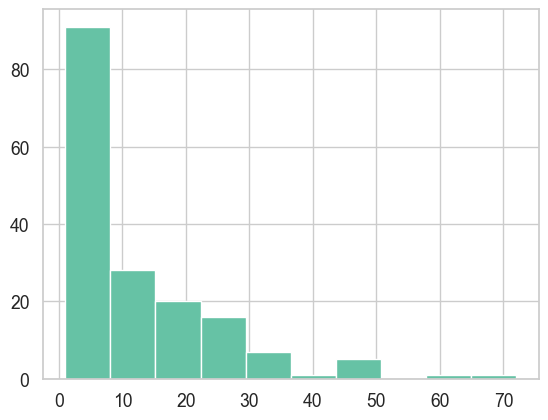

In [227]:
prod.groupby(['pr_group_id', 'pr_cat_id', 'pr_subcat_id'])['pr_sku_id'].count().hist();

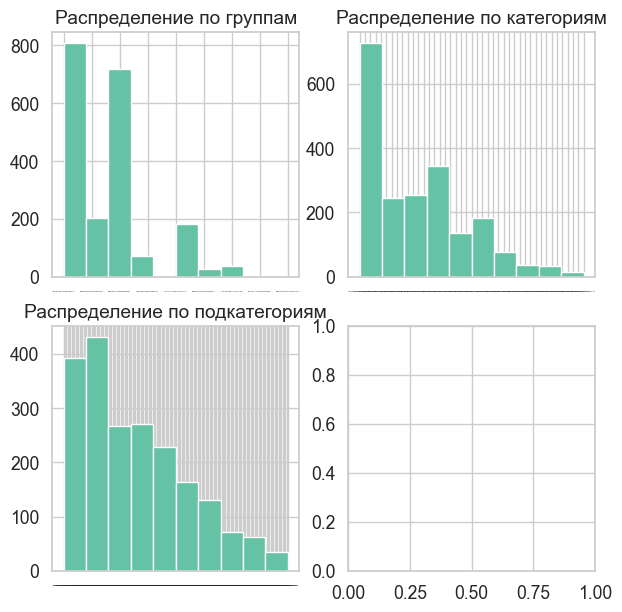

In [228]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
prod.pr_group_id.hist(xlabelsize=0, ax=axs[0,0]).set_title('Распределение по группам')
prod.pr_cat_id.hist(xlabelsize=0, ax=axs[0,1]).set_title('Распределение по категориям')
prod.pr_subcat_id.hist(xlabelsize=0, ax=axs[1,0]).set_title('Распределение по подкатегориям');

In [229]:
print('Количество групп товаров:', prod.pr_group_id.nunique(), 'Количество категорий товаров:',
 prod.pr_cat_id.nunique(), 'Количество подкатегорий товаров:', prod.pr_subcat_id.nunique(),
  'Количество товаров:', prod.pr_sku_id.nunique())

Количество групп товаров: 9 Количество категорий товаров: 43 Количество подкатегорий товаров: 170 Количество товаров: 2050


- для нахождения возможных корреляционных связей между различными категориями товаров, объединю данную таблицу с тренировочным датасетом.

****Предварительный анализ данных по магазинам:****

In [230]:
station = pd.read_csv('/Users/maiiayakusheva/Downloads/sp_sales_task/st_df.csv')

In [231]:
station

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
5,53e19f3dbb211f20b20b45668303c1b6,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,20,1
6,42a0e188f5033bc65bf8d78622277c4e,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
7,c81e728d9d4c2f636f067f89cc14862c,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
8,fa7cdfad1a5aaf8370ebeda47a1ff1c3,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
9,f7e6c85504ce6e82442c770f7c8606f0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1


In [232]:
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes


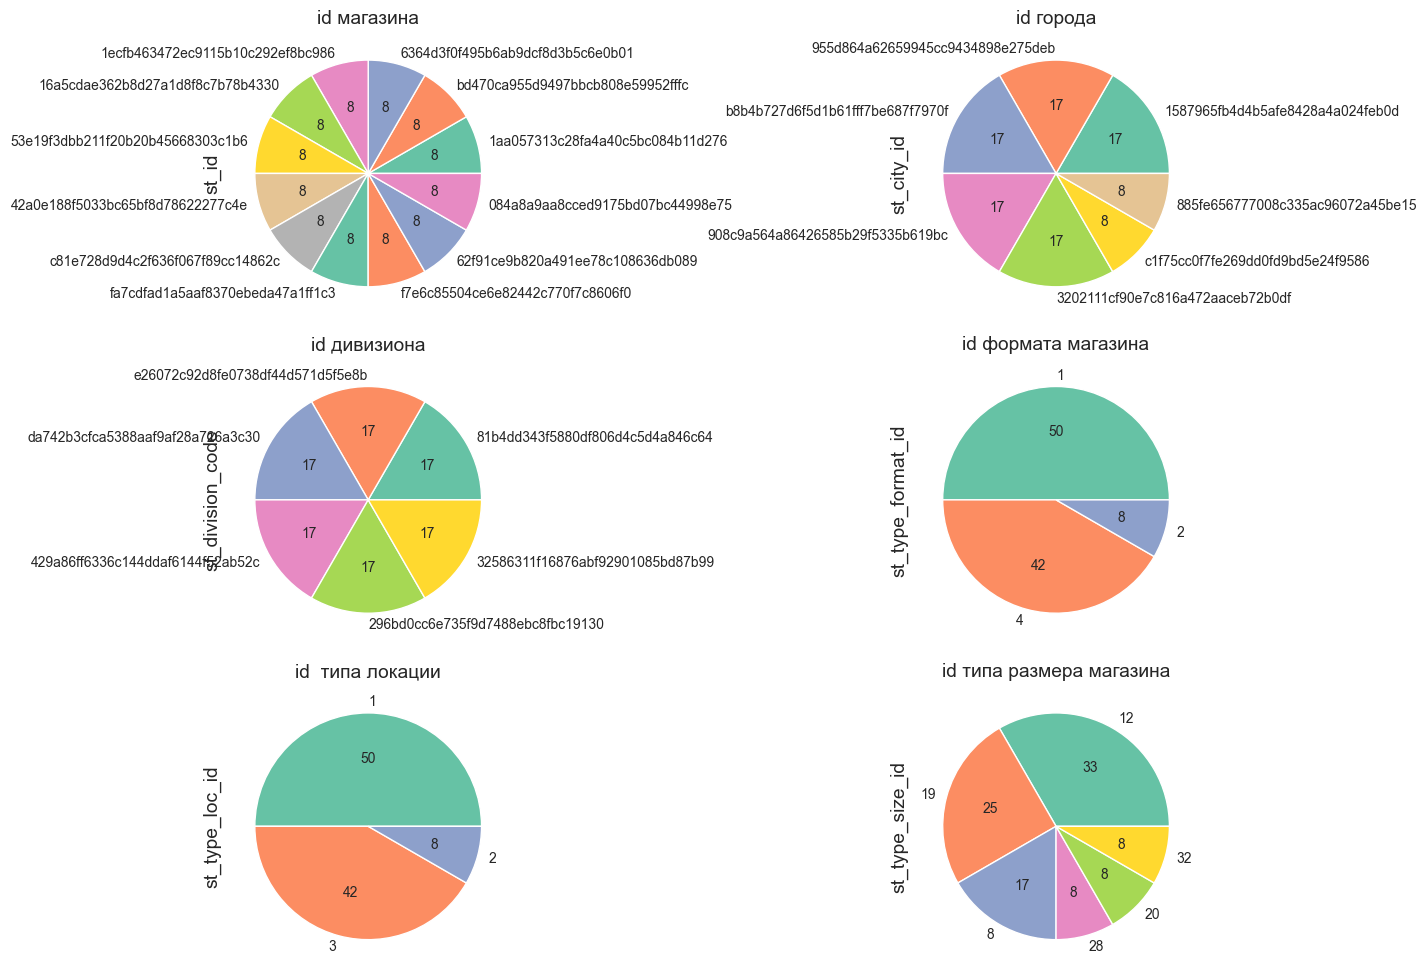

In [233]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(14, 10))
autopct='%.0f'
font_size=10
station.st_id.value_counts().plot.pie(autopct=autopct,fontsize=font_size, ax=axs[0, 0])\
    .set_title('id магазина')
station.st_city_id.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[0, 1])\
    .set_title('id города')
station.st_division_code.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[1, 0])\
    .set_title('id дивизиона')
station.st_type_format_id.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[1, 1])\
    .set_title('id формата магазина')
station.st_type_loc_id.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[2, 0])\
    .set_title('id  типа локации')
station.st_type_size_id.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[2, 1])\
    .set_title('id типа размера магазина')
fig.tight_layout()

In [234]:
station.st_is_active.value_counts().to_frame()

,st_is_active
1,10
0,2


- 2 магазина из 12 неактивны
- 12 магазинов распределены в равной пропорции примерно по 8%
- представлены 7 городов(на 5 приходится по 17% на 2 по 8%)
- есть 6 дивизионов(равномерно по 17%)
- закодированный формат магазина("1"-50%б "4"-42%, "2"-8%)
- три типа локации("1"-50%б "3"-42%, "2"-8%)
- 6 типов размерности магазинов("12"-33%, "19"-25%, "8"-17%, "20","28","32" - по 8%)

- эту таблицу также соединю с тренировочным датасетом для выявления корреляционных зависимостей.

In [235]:
data = df.merge(prod, on='pr_sku_id').merge(station, on='st_id')

***2) Разведочный анализ данных:***

- проведу анализ целевой переменной(количество проданных товаров в шт/кг): выясню как формировать целевую исходя из имеющихся двух столбцов с количеством(проданные с промо и без него)
- получу соотношение суммы продаж в день к количеству и получу признак со средней ценой в день, посмотрю на его распределение
- проведу анализ временных данных
- проведу анализ данных на выявление возможных корреляций целелевой переменной с присоединенными данными из таблиц по товарной иерархии и информации по магазинам
- анализ выбросов
- сделаю выводы

In [236]:
data[(data.pr_sales_in_units==data.pr_promo_sales_in_units)&(data.pr_sales_in_rub==data.pr_promo_sales_in_rub)]\
    .shape[0]/data.shape[0]

0.40122000683772413

- около 40% данных по количеству и сумме продаж идентичны, оставшаяся часть суммы и количества продаж без промо во всех случаях превышает соответствующие значения с флагом промо, отсюда я делаю вывод что в случаях, когда значения равны не было продаж с флагом промо, в остальных были и существует строка с продажей в эту дату с флагом промо, в дальнейшем, когда я буду создавать полный относительно временных меток датасет, я эти продажи сагрегирую и получу полное значение количества продаж и суммы продаж
- Итого: целевая переменная количество проданных товаров без признака промо

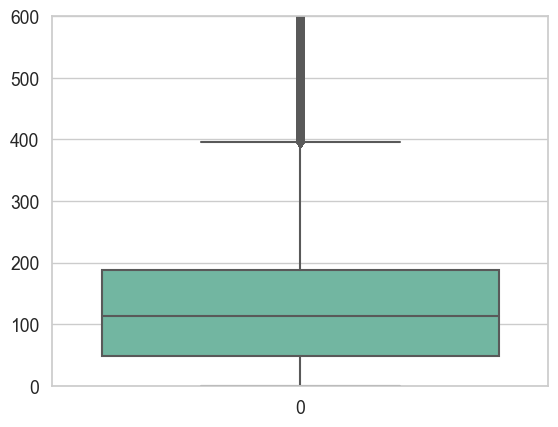

In [237]:
sns.boxplot(data=round(data.pr_sales_in_rub/data.pr_sales_in_units, 1)).set_ylim(0, 600);

In [238]:
round(data.pr_sales_in_rub/data.pr_sales_in_units, 1).median()

113.1

In [239]:
round(data.pr_sales_in_rub/data.pr_sales_in_units, 1).describe()

count    815607.000000
mean        138.856970
std         127.099226
min           0.100000
25%          49.100000
50%         113.100000
75%         187.800000
max        4729.000000
dtype: float64

- распределение отношения суммы продаж/количество продаж: медианное значение 113.1, среднее 138, соотвественно распределение смещено вправо, присутствуют выбросы, обусловленные выбросами признака сумма продаж. Для дальнейшего анализа создам признак со средней ценой за день

In [240]:
data['mean_price'] = round(data.pr_sales_in_rub/data.pr_sales_in_units, 1)

****анализ временных рядов:****

In [241]:
time_analys = data[['date', 'pr_sales_in_units']]

In [242]:
time_analys.index=time_analys.date

In [243]:
time_analys.drop('date', axis=1, inplace=True)

In [244]:
time_analys = time_analys.pr_sales_in_units

In [245]:
time_analys.index.is_monotonic_increasing

False

In [246]:
time_analys = time_analys.resample('1D').sum()

In [247]:
decomposed = seasonal_decompose(time_analys)

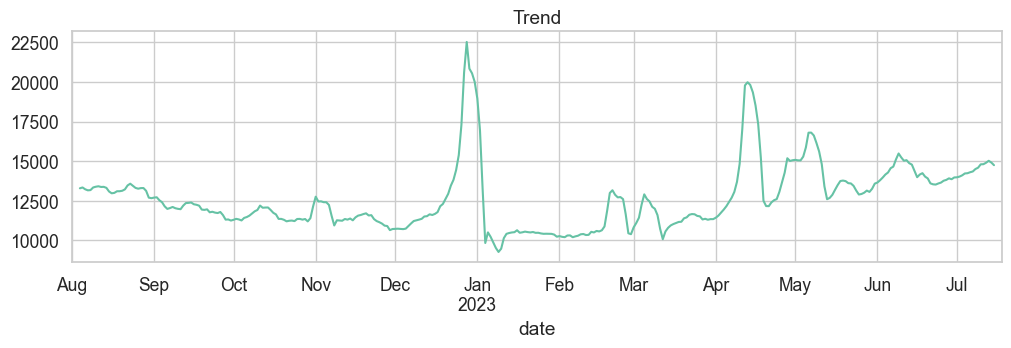

In [248]:
plt.figure(figsize=(12,3))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend');

- мы видим яркий тренд возрастания количества покупок в период новогодних праздников, чуть менее выраженные тренды, относящиеся к праздникам 23 февраля и 8 марта, также есть тренда возрастания количества покупок в середине апреля(начало сезона пикников), первой половине мая("майские праздники")
- далее я посмотрю на сезонность:

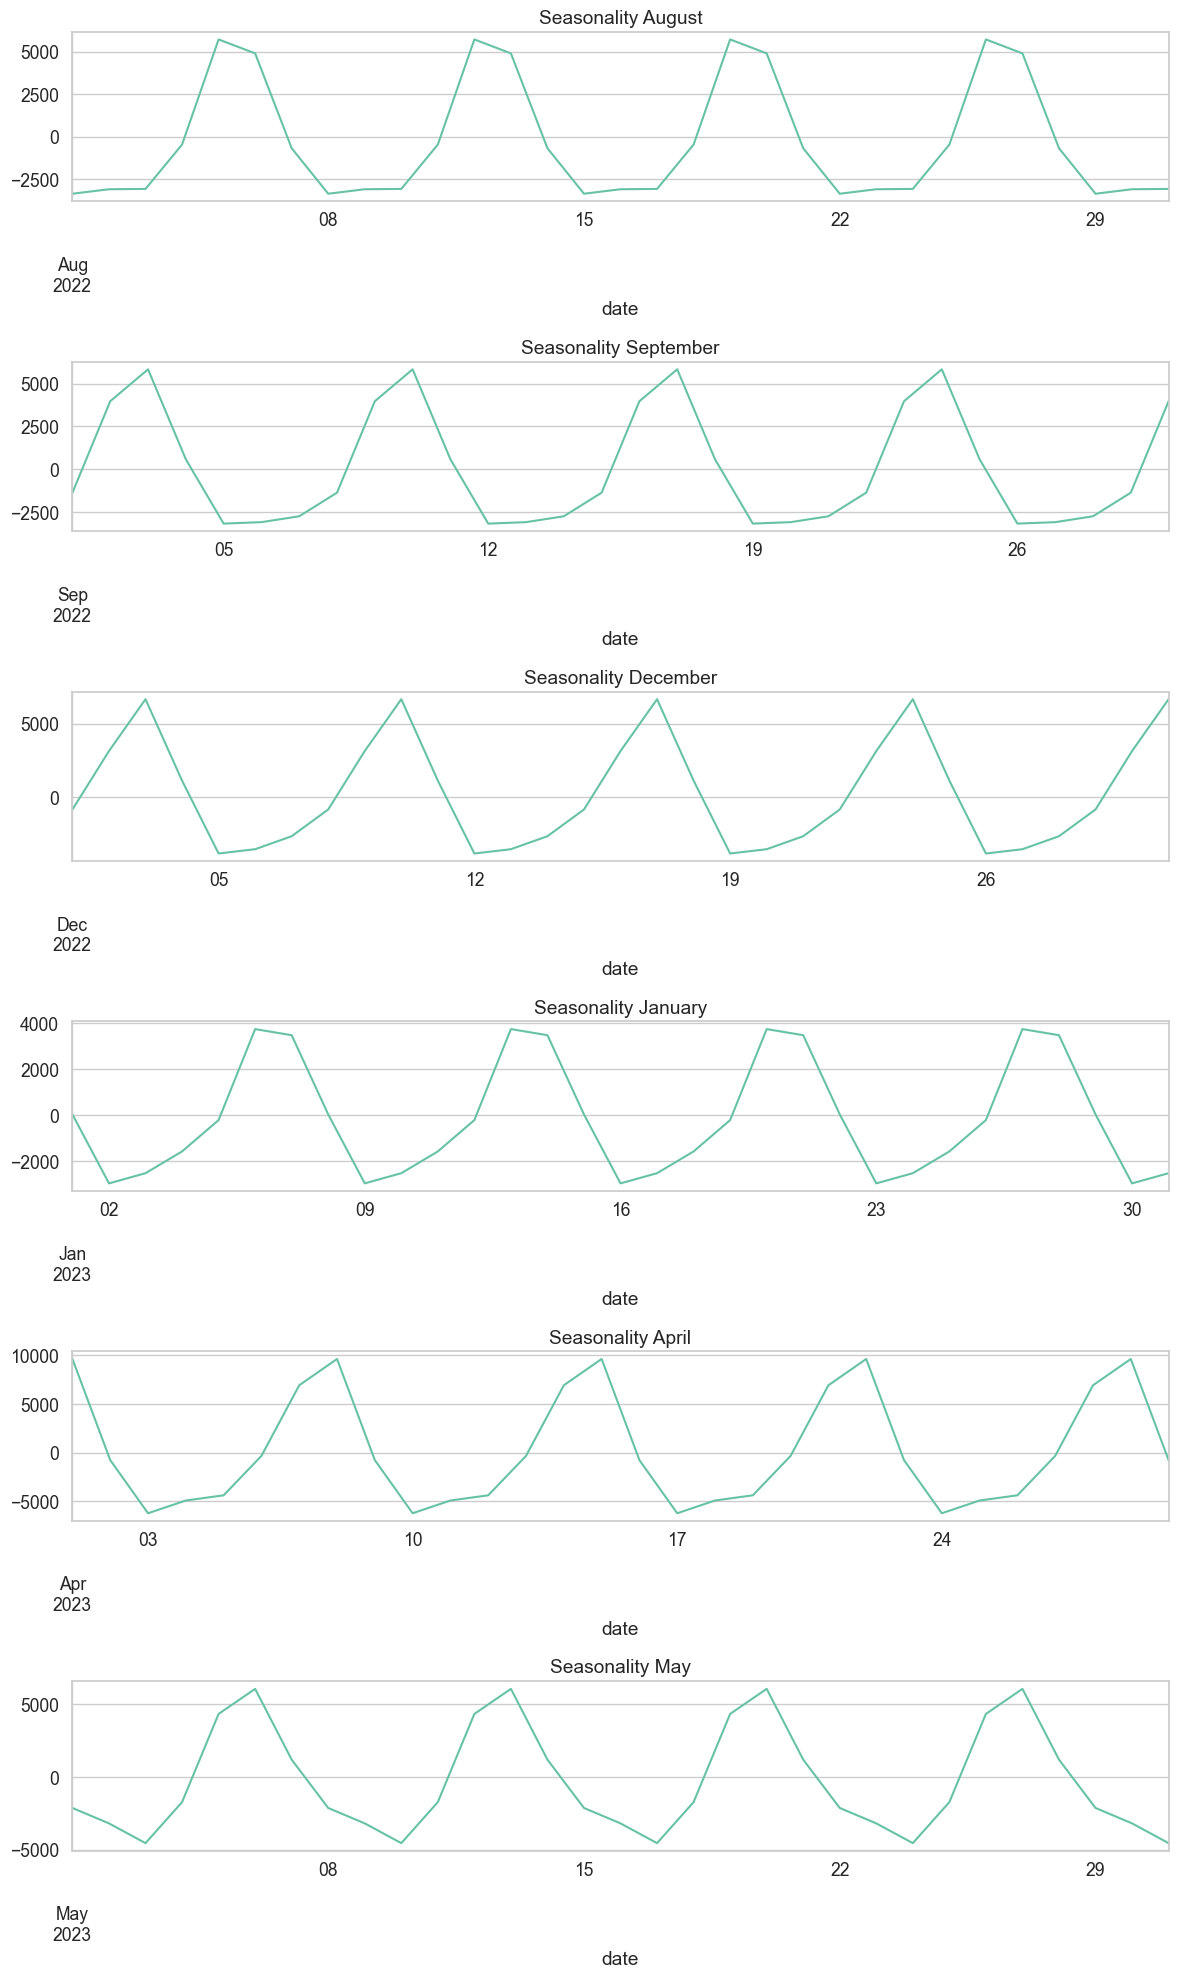

In [249]:
plt.figure(figsize=(12,20))
plt.subplot(611)
seasonal_decompose(time_analys['2022-08-01':'2022-08-31']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality August')
plt.subplot(612)
seasonal_decompose(time_analys['2022-09-01':'2022-09-30']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality September')
plt.subplot(613)
seasonal_decompose(time_analys['2022-12-01':'2022-12-31']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality December')
plt.subplot(614)
seasonal_decompose(time_analys['2023-01-01':'2023-01-31']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality January')
plt.subplot(615)
seasonal_decompose(time_analys['2023-04-01':'2023-04-30']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality April')
plt.subplot(616)
seasonal_decompose(time_analys['2023-05-01':'2023-05-31']).seasonal.plot(ax=plt.gca())
plt.title('Seasonality May')

plt.tight_layout();

- по визуализации заметно, что точки максимума и минимума в помесячных графиках сезонности составляют разные значения, но тем не менее полный цикл изменения целевого признака во всех случаях около 7 дней
- проведу тест Дики-Фуллера для проверки стационарности временного ряда, также построю графики автокорреляции

In [250]:
def tsplot(y, lags=None, figsize=(12, 4), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()
    return

Критерий Дики-Фуллера: p=0.014524


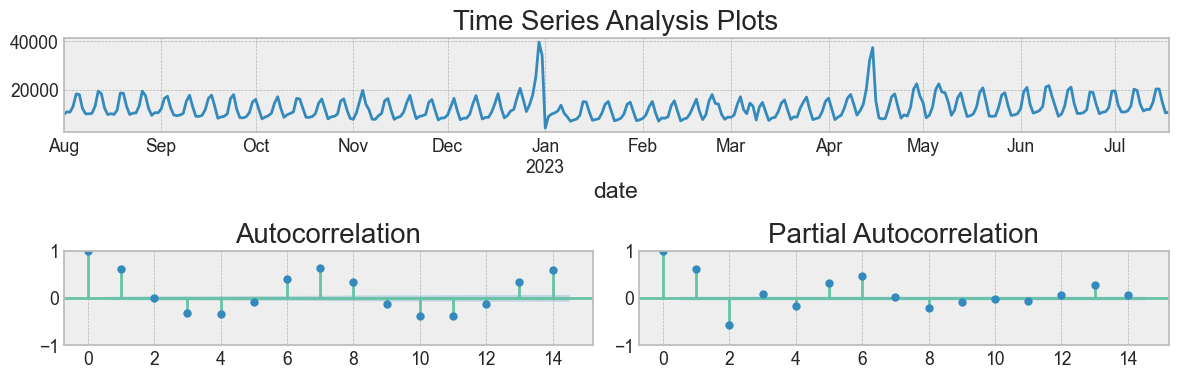

In [251]:
tsplot(time_analys, lags=14)

- мы видим(и получаем подтверждение по критерию оценки Дики-Фуллера), что данный временной ряд относится к классу ТS(ряды, становящиеся стационарными после вычитания из них детерминированного тренда)
- также графики автокорреляции подтверждают гипотезу о том, что колебания целевой переменной укладываюся в период равный 7 дням(эта информация полезна для выбора размера скользящего окна).

****анализ, направленный на выяление корреляционных связей целевой переменной с присоединенными данными из таблиц с информацией по товарной иерархии и по магазинам:****

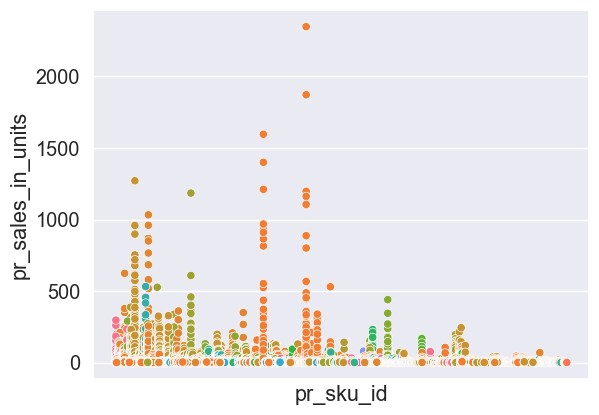

In [252]:
sns.set(font_scale=1.3)
sns.scatterplot(
    x='pr_sku_id', 
    y='pr_sales_in_units', 
    data=data, hue='pr_cat_id',
    legend=False)
plt.xticks([])

plt.show()

- так выглядит распределение целевой переменной по товарам, подсвеченная по категориям товаров, визуально видно, что товары некоторых категорий пользуются гораздо большим спросом, но так как неудобно выводить достаточно длинные захэшированные названия категорий товарной иерархии, я приведу эти распределения в табличном виде: 

In [253]:
data.groupby(['pr_group_id', 'pr_cat_id', 'pr_subcat_id'])['pr_sales_in_units']\
    .sum().sort_values(ascending=False).head(20).to_frame()

pr_sales_in_units
pr_group_id                      pr_cat_id                        pr_subcat_id                                       
c74d97b01eae257e44aa9d5bade97baf c559da2ba967eb820766939a658022c8 e06f5ed77191826c212c30722f2cc5a2           445606.0
6512bd43d9caa6e02c990b0a82652dca e58cc5ca94270acaceed13bc82dfedf7 c93c26cd49ea08e6b8984351d4164575           328480.0
                                                                  120e4b609af49ff7b17c3b90e7a28435           193552.0
aab3238922bcc25a6f606eb525ffdc56 186a157b2992e7daed3677ce8e9fe40f aa36dc1d45661519a5bf923429776a83           179511.0
c20ad4d76fe97759aa27a0c99bff6710 fb2fcd534b0ff3bbed73cc51df620323 45551f4c29881972ae5ed3666a5b1b8b           177175.0
c74d97b01eae257e44aa9d5bade97baf c559da2ba967eb820766939a658022c8 130d817d8b3f616e97c555ec57946aec           164110.0
                                                                  1e2248e0a1305fdf1dca5510e06a2b96           128173.0
                                                                  6e84696301885ba0a9dc8de6fe45abd0           117685.0
c20ad4d76fe97759aa27a0c99bff6710 fb2fcd534b0ff3bbed73cc51df620323 c005b9a2626f6c1946e1851628724b18           104787.0
6512bd43d9caa6e02c990b0a82652dca c9f95a0a5af052bffce5c89917335f67 126ad03316db7675164e3f0c8be270e9           103264.0
c74d97b01eae257e44aa9d5bade97baf 1bc0249a6412ef49b07fe6f62e6dc8de ca34f669ae367c87f0e75dcae0f61ee5            99462.0
aab3238922bcc25a6f606eb525ffdc56 28fc2782ea7ef51c1104ccf7b9bea13d b3e70d072fc648f6934c288e44f5c35e            96286.0
c74d97b01eae257e44aa9d5bade97baf c559da2ba967eb820766939a658022c8 34d2777e78ccf007523e2dd1fcea6b2d            91459.0
aab3238922bcc25a6f606eb525ffdc56 3de2334a314a7a72721f1f74a6cb4cee 0f3abfd67959c079e7b3759440e7415c            89953.0
                                 28fc2782ea7ef51c1104ccf7b9bea13d 7a8aebb07d6e8ba9da453ec0f3f359a4            89937.0
c74d97b01eae257e44aa9d5bade97baf 1bc0249a6412ef49b07fe6f62e6dc8de d407a3ebb4ab9b0d68b224486f8b8dad            84139.0
                                 c559da2ba967eb820766939a658022c8 89b0107c6d0aca5f15fa7a715f9e06e5            83330.0
                                 1bc0249a6412ef49b07fe6f62e6dc8de 1507fc0175c1ff0cf4440105bc6f93e6            82890.0
aab3238922bcc25a6f606eb525ffdc56 28fc2782ea7ef51c1104ccf7b9bea13d d29b5ce9c2883f0b7e90f79071a2ca82            76513.0
c74d97b01eae257e44aa9d5bade97baf f3173935ed8ac4bf073c1bcd63171f8a 5fd72b9fc7118bd36a137d7cea8c588a            73773.0

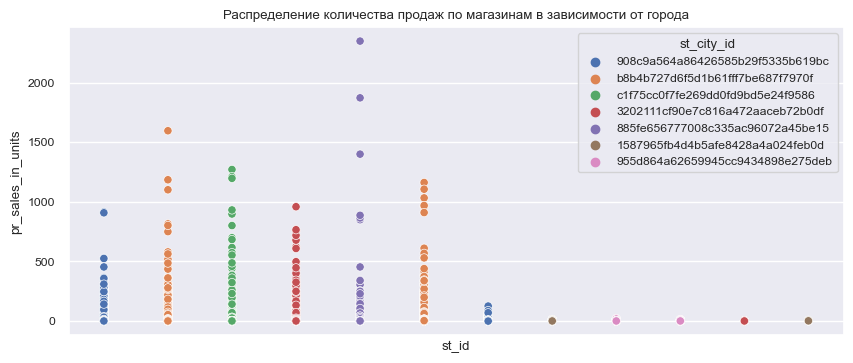

In [254]:
sns.set(font_scale=0.8)
plt.figure(figsize=(10, 4))
sns.scatterplot(
    x='st_id', 
    y='pr_sales_in_units', 
    data=data, hue='st_city_id')   
plt.xticks([])
plt.title('Распределение количества продаж по магазинам в зависимости от города')
plt.show()

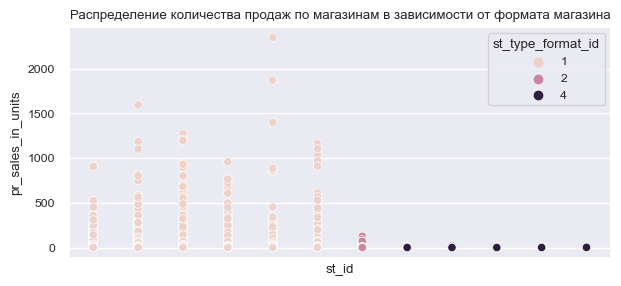

In [255]:
sns.set(font_scale=0.8)
plt.figure(figsize=(7, 3))
sns.scatterplot(
    x='st_id', 
    y='pr_sales_in_units', 
    data=data, hue='st_type_format_id')   
plt.xticks([])
plt.title('Распределение количества продаж по магазинам в зависимости от формата магазина')
plt.show()

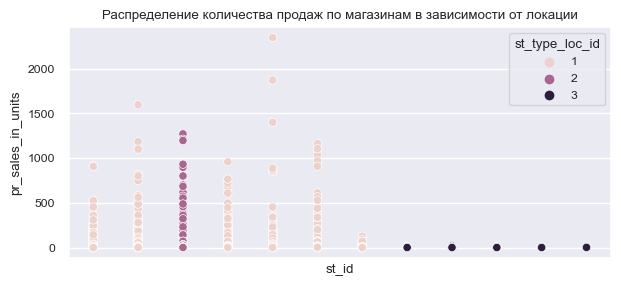

In [256]:
sns.set(font_scale=0.8)
plt.figure(figsize=(7, 3))
sns.scatterplot(
    x='st_id', 
    y='pr_sales_in_units', 
    data=data, hue='st_type_loc_id')   
plt.xticks([])
plt.title('Распределение количества продаж по магазинам в зависимости от локации')
plt.show()

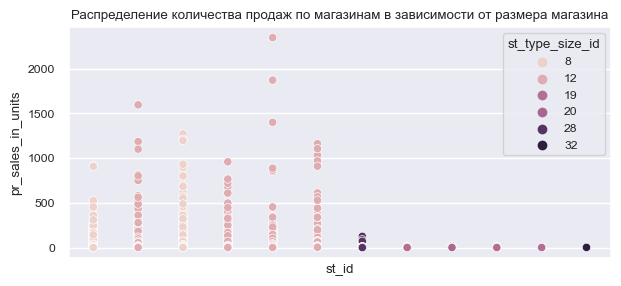

In [257]:
sns.set(font_scale=0.8)
plt.figure(figsize=(7, 3))
sns.scatterplot(
    x='st_id', 
    y='pr_sales_in_units', 
    data=data, hue='st_type_size_id')   
plt.xticks([])
plt.title('Распределение количества продаж по магазинам в зависимости от размера магазина')
plt.show()

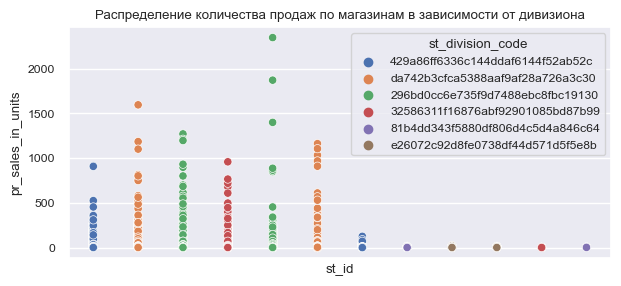

In [258]:
sns.set(font_scale=0.8)
plt.figure(figsize=(7, 3))
sns.scatterplot(
    x='st_id', 
    y='pr_sales_in_units', 
    data=data, hue='st_division_code')   
plt.xticks([])
plt.title('Распределение количества продаж по магазинам в зависимости от дивизиона')
plt.show()

- в таблицах и на графиках явно заметна зависимость целевой переменной от категорий товарной иерархии, так и от категорий данных по магазинам. Следовательно необходимо внести эти данные в качестве категориальных признаков для работы с моделями.

- существуют несколько магазинов с неактивным флагом на данный момент, необходимо решить вопрос о целесообразности внесения этих данных в набор признаков, для этого посмотрю на распределение данных по этим магазинам:

In [259]:
data.st_is_active.value_counts().to_frame(name='Итого:')

,Итого:
1,815334
0,727


In [260]:
data.groupby('st_is_active')['pr_sales_in_units'].sum()

st_is_active
0       2282.0
1    4443020.0
Name: pr_sales_in_units, dtype: float64

- крайне малое количество продаж по неактивным магазинам, я удалю эти данные

In [261]:
data = data[data.st_is_active==1]

- необходимо проверить выбросы со слишком большим количеством продаж, чтобы принять решение об их включение в итоговый состав признаков:
  - выделю количества продаж распределение которых больше 95 процентиля
  - при помощи библиотеки holidays(в которую добавлю предпраздничные дни с повышенным спросом) отделю праздники

In [262]:
data[data.pr_sales_in_units>np.percentile(data.pr_sales_in_units, 95)].pr_sales_in_units\
    .sort_values(ascending=False).head(20).to_frame()

,pr_sales_in_units
627573,2348.0
627564,1872.0
262911,1596.0
622577,1400.0
295260,1271.0
402446,1211.0
411835,1197.0
233017,1185.0
754207,1162.0
754222,1106.0


In [263]:
big_sales = data[data.pr_sales_in_units>np.percentile(data.pr_sales_in_units, 95)]\
    [['date', 'pr_sales_in_units']]

In [264]:
outliers_threshold = np.percentile(data.pr_sales_in_units, 95)

In [265]:
import holidays

In [266]:
holidays_list = []
for i in holidays.RUS(years=[2022, 2023]).items():
    holidays_list.append(str(i[0]))

In [267]:
holidays_list = holidays_list + ['2022-12-31', '2022-12-30', '2022-12-29', '2022-02-22', '2022-03-07',
 '2023-02-22', '2023-02-23', '2023-03-07']

In [268]:
big_sales['is_holiday'] = [1 if str(val).split()[0] in holidays_list else 0 for val in big_sales.date]

In [269]:
big_sales.is_holiday.value_counts()

0    35169
1     3110
Name: is_holiday, dtype: int64

- теперь необходимо проверить оставшиеся даты:
  - посмотрю на распределение по дням недели, месяцам

In [270]:
outliers_ = big_sales[big_sales.is_holiday==0]

In [271]:
outliers_grouped=pd.DataFrame(outliers_.groupby(outliers_.date)['pr_sales_in_units'].sum())

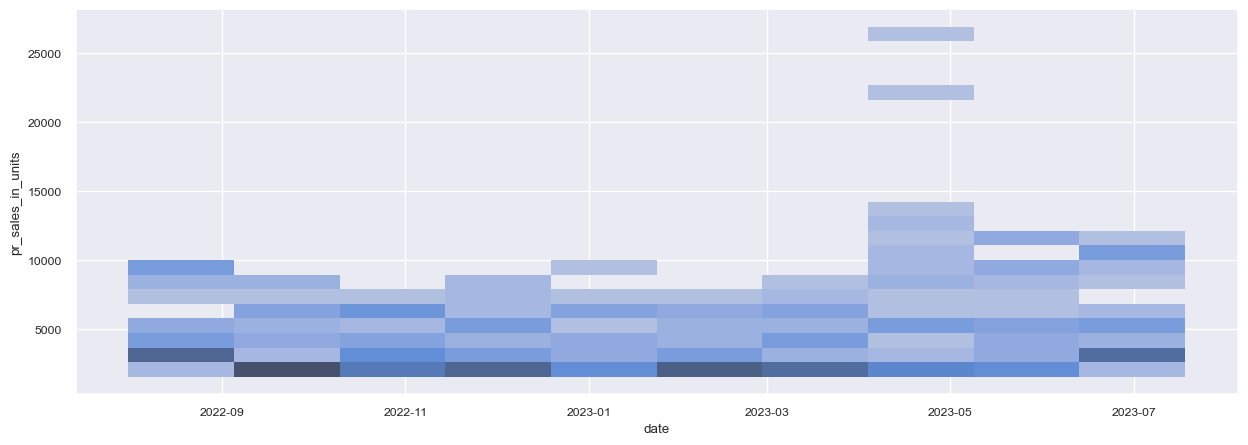

In [272]:
plt.figure(figsize=(15, 5))
sns.histplot(data=outliers_grouped, x=outliers_grouped.index, y='pr_sales_in_units');

In [273]:
outliers_.date.dt.day_name().value_counts().to_frame()

,date
Saturday,8545
Friday,7447
Sunday,5557
Thursday,4452
Wednesday,3298
Tuesday,3104
Monday,2766


In [274]:
outliers_.date.dt.month_name().value_counts().to_frame()

,date
June,3816
August,3646
April,3620
May,3414
September,3172
October,2982
December,2976
November,2628
March,2573
July,2440


- распределение по дням недели и месяцам равномерное
- введу в общий датасет столбец с бинарным флагом является ли дата праздничной
- проверю имеющиеся выбросы на наличие в эти дни промо-акций

In [275]:
#[1 for x in outliers_.date if x in data[data.pr_sales_type_id==1].date].count(1)

- я закомментировала прошлую функцию, чтобы скоратить время чтения тетради(16 мин), но полученый в итоге результат - 35169 в точности совпадает с нашими "необъясниимыми выбросами". Итого эти 35169 строк это то, когда промо-акции действительно "сработали" и продажи значительно увеличились! И я приняла решение удалить имеющийся бинарный столбец со всеми промо-акциями и создать новый, где флаг промо будет стоять только на реально сработавших акциях

- далее я посмотрю на имеющиеся взаимосвязи среди имеющихся признаков по средствам библиотеки phik(сразу преобразую некоторые категориальные признаки, имеющие числовой тип в object)
- также построю тепловую карту корреляции для численных признаков

In [276]:
data.pr_uom_id = data.pr_uom_id.astype(str)
data.st_type_format_id = data.st_type_format_id.astype(str)
data.st_type_loc_id = data.st_type_loc_id.astype(str)
data.st_type_size_id = data.st_type_size_id.astype(str)

In [277]:
import phik

In [278]:
data.drop('date', axis=1).phik_matrix()

interval columns not set, guessing: ['pr_sales_type_id', 'pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub', 'st_is_active', 'mean_price']


,st_id,pr_sku_id,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,mean_price
st_id,1.000000,0.920496,0.098918,0.001429,0.000000,0.017038,0.016074,0.172474,0.376970,0.558701,0.303604,1.000000,1.000000,1.000000,1.000000,1.000000,0.051688
pr_sku_id,0.920496,1.000000,0.385576,0.276119,0.302225,0.219096,0.205249,1.000000,1.000000,1.000000,1.000000,0.860283,0.878444,0.974781,0.890337,0.912770,0.914837
pr_sales_type_id,0.098918,0.385576,1.000000,0.012785,0.016796,0.032208,0.038952,0.178482,0.252511,0.292974,0.079984,0.104251,0.061185,0.027295,0.029232,0.039057,0.068501
pr_sales_in_units,0.001429,0.276119,0.012785,1.000000,0.998936,0.575806,0.568203,0.016773,0.019192,0.069872,0.004452,0.003991,0.002794,0.000000,0.000000,0.000000,0.000000
pr_promo_sales_in_units,0.000000,0.302225,0.016796,0.998936,1.000000,0.584733,0.596932,0.019662,0.023957,0.078331,0.004225,0.002983,0.001095,0.000000,0.000000,0.000000,0.000000
pr_sales_in_rub,0.017038,0.219096,0.032208,0.575806,0.584733,1.000000,0.999029,0.073033,0.102343,0.147495,0.024247,0.019520,0.015496,0.013735,0.031797,0.008138,0.061015
pr_promo_sales_in_rub,0.016074,0.205249,0.038952,0.568203,0.596932,0.999029,1.000000,0.072647,0.099188,0.141865,0.022639,0.018540,0.013325,0.012441,0.030400,0.007655,0.055330
pr_group_id,0.172474,1.000000,0.178482,0.016773,0.019662,0.073033,0.072647,1.000000,1.000000,1.000000,0.653457,0.176922,0.166678,0.251581,0.196849,0.149959,0.380801
pr_cat_id,0.376970,1.000000,0.252511,0.019192,0.023957,0.102343,0.099188,1.000000,1.000000,1.000000,0.945271,0.358959,0.357952,0.384849,0.308865,0.339497,0.580491
pr_subcat_id,0.558701,1.000000,0.292974,0.069872,0.078331,0.147495,0.141865,1.000000,1.000000,1.000000,0.980875,0.530373,0.540048,0.582054,0.492300,0.535992,0.723402


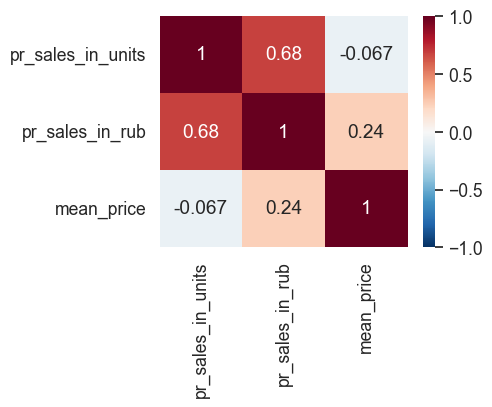

In [279]:
sns.set(font_scale=1.15)
plt.figure(figsize=(4,3))
sns.heatmap(
    data[['pr_sales_in_units', 'pr_sales_in_rub', 'mean_price']].corr(),        
    cmap='RdBu_r', 
    annot=True,
    vmin=-1, vmax=1);

- phik матрица показывает взаимосвязи, имеющиеся как между численными, так между категориальными данными: если судить по ней все данные, относящиеся к иерархической структуре магазинов не имеют никакого влияния на целевую переменную, как и признак того продается ли товар поштучно или наразвес. Я возьму эти данные на вооружение, но пока эти признаки удалять не буду, приму решение на валидации(посмотрев еще и на важность признаков для модели)
- тепловая карта показывает крайне низкую корреляцию между целевой переменной и нововведенным столбцом со средней ценой, его я удалю.

****Выводы:****

- определена целевая переменная - количество проданных единиц товара
- вновь созданный признак со средней ценой дает низкую корреляцию с целевой переменной, его тоже следует удалить
- судя по анализу временных рядов колебания целевой переменной укладываюся в интервал из 7 дней, эта информация будет учтена при формировании лагов
- несмотря на результаты работы с библиотекой phik пока оставлю в наборе признаков категориальные данные об иерархической структуре магазинов и бинарного столбца с типом продаваемой продукции(по крайней мере до изучения важности признаков для модели на валидации), данные по товарной иерархии также пока оставлю в наборе признаков
- из датасета удалены данные из неактивных магазинов(в связи с их крайне маленьким размером), аналогичный столбец также удалю
- необходимо создать бинарный столбец является ли дата праздничным днем
- имеющиеся выбросы с очень большим объемом продаж, не приходящимся на праздничные дни, определены как продажи с хорошо "сработавшей" промо-акцией, и я создам новый столбец, в котором бинарным индикатором будут отмечены именно сработавшие акции, и в связи с этим необходимо удалить три столбцам с характеристиками, посвещенными промо.

***3) Подготовка признаков для работы с моделью:***

- сначала я проведу все преобразования с датасетом, указанные в выводах к разведочному анализу данных
- воссоздам полный временной ряд со всеми уникальными сочетаниями магазин-товар
- введу признак с наличием/отсутствием праздничного дня
- сразу отделю тестовую часть датасета, чтобы исключить "подглядывание" в будущее
- проведу лагирование численных признаков из набора
- создам временные признаки из индекса

In [280]:
data.drop(['pr_sales_type_id', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub', 'st_is_active',
 'mean_price'], axis=1, inplace=True)

- после удаления выбранных столбцов и создание нового столбца с флагом промо и с флагом наличия праздничного дня, приступлю к созданию таблицы, содержащей в себе полный временной ряд за период, указанный в нашем датасете, и все уникальные сочетания магазин-товар из датасета
- затем соединю эту таблицу с имеющимся датасетом, чтобы восстановить временную последовательность

In [281]:
import datetime as DT

In [282]:
start_date = '2022-08-01'
end_date = '2023-07-18'
date_seq = pd.date_range(start=start_date, end=end_date, freq='D')

In [283]:
date_df = pd.DataFrame({'date': date_seq})

In [284]:
seq_df = data[['st_id', 'pr_sku_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'st_city_id',
    'st_division_code', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id']]\
        .drop_duplicates()

In [285]:
date_grid = date_df.merge(seq_df, how='cross')

In [286]:
date_grid.date = pd.to_datetime(date_grid.date)

In [287]:
temp_data = date_grid.merge(data[['st_id', 'pr_sku_id', 'date', 'pr_sales_in_units', 'pr_sales_in_rub']],
 on=['st_id', 'pr_sku_id', 'date'], how='left')

In [288]:
temp_data.isna().sum()

date                       0
st_id                      0
pr_sku_id                  0
pr_group_id                0
pr_cat_id                  0
pr_subcat_id               0
pr_uom_id                  0
st_city_id                 0
st_division_code           0
st_type_format_id          0
st_type_loc_id             0
st_type_size_id            0
pr_sales_in_units    1496568
pr_sales_in_rub      1496568
dtype: int64

In [289]:
temp_data.fillna(0, inplace=True)

In [290]:
temp_data.shape

(2311902, 14)

In [291]:
data = temp_data.groupby(['date', 'st_id', 'pr_sku_id', 'pr_group_id', 'pr_cat_id',
       'pr_subcat_id', 'pr_uom_id', 'st_city_id', 'st_division_code',
       'st_type_format_id', 'st_type_loc_id', 'st_type_size_id']).\
              agg(pr_sales_in_units=('pr_sales_in_units', 'sum')).reset_index()

In [292]:
data.date.value_counts().to_frame()

,date
2022-08-01,6130
2022-08-02,6130
2023-03-29,6130
2023-03-28,6130
2023-03-27,6130
...,...
2022-11-24,6130
2022-11-23,6130
2022-11-22,6130
2022-11-21,6130


In [293]:
data.pr_sales_in_units.value_counts().to_frame()

,pr_sales_in_units
0.0,1496748
1.0,165133
2.0,120772
3.0,80191
4.0,67702
...,...
992.0,1
446.0,1
462.0,1
246.0,1


Итого нами получен датасет содержащий полный набор временных отметок для каждого уникального сочетания товар-магазин.

- Получим признак присутствует ли в данной строке "сработавшая" промо-акция(было описано в выводах к разведочному анализу данных)

In [294]:
data['is_promo'] = pd.Series(np.where((data.pr_sales_in_units>np.percentile(data.pr_sales_in_units, 95))\
     & (big_sales.is_holiday==0), 1, 0), index=data.index)
data.is_promo = data.is_promo.astype(str)
data.is_promo.value_counts().to_frame()

,is_promo
0,2156084
1,1676


- теперь присоединим тестовую часть датасета, предварительно соединив ее с данными из таблиц по товарной и продуктовой иерархии:

In [295]:
data = data.rename(columns={'pr_sales_in_units': 'target'})

In [296]:
sub = pd.read_csv('/Users/maiiayakusheva/Downloads/sp_sales_task/sales_submission.csv')
sub.date = pd.to_datetime(sub.date)
sub.index = sub.date
sub.sort_index(inplace=True)

In [297]:
sub = sub.merge(prod, on=['pr_sku_id'], how='left').merge(station, on=['st_id'], how='left')

In [298]:
sub['is_promo']=0

In [299]:
full = pd.concat([data, sub], axis=0).drop('st_is_active', axis=1)

- теперь создадим новый бинарный признак, который дает ответ является ли данная дата праздничным или предпраздничным днем
- также получим "временные" признаки из даты

In [300]:
full['is_holiday'] = [1 if str(val).split()[0] in holidays_list else 0 for val in full.date]
full.is_holiday = full.is_holiday.astype(str)

In [301]:
full['month'] = full.date.dt.month.astype(str)
full['day_of_week'] = full.date.dt.day_of_week.astype(str)
full['day_of_year'] = full.date.dt.day_of_year.astype(str)
full['day'] = full.date.dt.day.astype(str)
full['year_end'] = full.date.dt.is_year_end.astype(str)
full['year'] = full.date.dt.year.astype(str)

- теперь я сгенерирую дополнительный признак - вероятность появления выброса в данных(на основе праздничных, предпраздничных дней или сработавшей промо-акции, здесь воспользуюсь константой, введенной в разведочном анализе данных). Для бинарной классификации воспользуюсь моделью Логистической регрессии, предварительно закодировав данные TargetEncoder и применив StandartScaler.

In [302]:
class_df = full.copy()

In [303]:
class_df['outliers'] = pd.Series(np.where(class_df.target>outliers_threshold, 1, 0))

In [304]:
train_class = class_df[class_df.date<='2023-07-18']
test_class = class_df[class_df.date>'2023-07-18']
X_train_class = train_class.drop(['outliers', 'is_promo', 'is_holiday', 'date'], axis=1)
y_train_class = train_class.outliers
X_test_class = test_class.drop(['outliers', 'is_promo', 'is_holiday', 'date'], axis=1)
y_test_class = test_class.outliers

In [305]:
cat_col = ['st_id', 'pr_sku_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id',
       'pr_uom_id', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'month', 'day_of_week', 'day_of_year',
       'day', 'year_end', 'year']
num_col = ['target']

In [306]:
enc = TargetEncoder(target_type='continuous', smooth='auto')
scaler = StandardScaler()

In [307]:
enc.fit(X_train_class[cat_col], y_train_class)
enc_cols = enc.get_feature_names_out(X_train_class[cat_col].columns)
X_train_class_enc = pd.DataFrame(enc.transform(X_train_class[cat_col]), columns=enc_cols,
 index=X_train_class[cat_col].index)
X_test_class_enc = pd.DataFrame(enc.transform(X_test_class[cat_col]), columns=enc_cols,
 index=X_test_class[cat_col].index)

In [308]:
scaler.fit(X_train_class[num_col])
colss = scaler.get_feature_names_out(X_train_class[num_col].columns)
X_train_class_scaled = pd.DataFrame(scaler.transform(X_train_class[num_col]), columns=colss,
 index=X_train_class[num_col].index)
X_test_class_scaled = pd.DataFrame(scaler.transform(X_test_class[num_col]), columns=colss,
 index=X_test_class[num_col].index)
X_train_class = pd.concat([X_train_class_enc, X_train_class_scaled], axis=1)
X_test_class = pd.concat([X_test_class_enc, X_test_class_scaled], axis=1)

In [309]:
scoring = make_scorer(precision_score, greater_is_better=True)
tscv = TimeSeriesSplit(n_splits=6)
logr = LogisticRegression()
parametrs = {}
logr_grid = GridSearchCV(logr, parametrs, scoring=scoring, cv=tscv)
logr_grid.fit(X_train_class, y_train_class)
all_class_preds = logr_grid.best_estimator_.predict_proba(X_train_class)
test_class_preds = logr_grid.best_estimator_.predict_proba(X_test_class)[:,1]
full['probs'] = pd.Series(all_class_preds[:,1])

- итого мы получили предсказания для обучающей выборки и отдельно для тестовой части.

- теперь отделю тестовую и тренировочную части датасета, чтобы внести отдельно признак с предсказаниями вероятности появления выбросов на тестовой выборке, таргет в тесте оставлю нулевым.

In [310]:
y_test = full[full.date>'2023-07-18'].target
temp_test = full[full.date>'2023-07-18'].drop(['target', 'probs'], axis=1)
data = full[full.date<='2023-07-18']
temp_test['target']=0
temp_test['probs']=test_class_preds
data = pd.concat([data, temp_test], axis=0)
data = data.sort_values(by=['date', 'st_id', 'pr_sku_id'])

- получу признаки с лагами целевой переменной

In [311]:
data.index = data.date
for n in range(14, 36, 7):
    data[f'lag{n}'] = data.target\
        .shift(data.date.value_counts().values[0]*n)
data.dropna(inplace=True)

- разделим тренировочную и тестовую части(с полученными лагами)
- также разделим оставшийся датасет на тренировочную и валидационную части

In [312]:
train_data = data[data.date<='2023-07-18']
test_data = data[data.date>'2023-07-18']
X = train_data.drop('target' , axis=1)
y = train_data.target
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.2)

- теперь наши данные необходимо закодировать и нормальзовать

In [313]:
nums = ['lag14', 'lag21', 'lag28', 'lag35', 'probs']
cats = ['st_id', 'pr_sku_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'st_city_id',
    'st_division_code', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'is_holiday',
    'month', 'day_of_week', 'day_of_year', 'day', 'year_end', 'year']

In [314]:
enc.fit(X_train[cats], y_train)
new_columns = enc.get_feature_names_out(X_train[cats].columns)
X_train_enc = pd.DataFrame(enc.transform(X_train[cats]), columns=new_columns, index=X_train[cats].index)
X_val_enc = pd.DataFrame(enc.transform(X_val[cats]), columns=new_columns, index=X_val[cats].index)
scaler.fit(X_train[nums])
col = scaler.get_feature_names_out(X_train[nums].columns)
X_train_scaled = pd.DataFrame(scaler.transform(X_train[nums]), columns=col, index=X_train[nums].index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val[nums]), columns=col, index=X_val[nums].index)
X_train = pd.concat([X_train_enc, X_train_scaled], axis=1)
X_val = pd.concat([X_val_enc, X_val_scaled], axis=1)

***4) Обучение и валидация моделей:***

- напишу функцию для вычисления метрики WAPE
- проведу обучение и валидацию моделей буду использовать модель Линейной регрессии и модель градиентного бустинга от lightgbm

In [315]:
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

In [316]:
score = make_scorer(wape, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=6)
lr = LinearRegression()
parametrs = {}
lr_grid = GridSearchCV(lr, parametrs, scoring=score, cv=tscv)
lr_grid.fit(X_train, y_train)
wape(y_val, lr_grid.best_estimator_.predict(X_val))

0.6774645318424009

In [317]:
r2_score(y_val, lr_grid.best_estimator_.predict(X_val))

0.6900776293519144

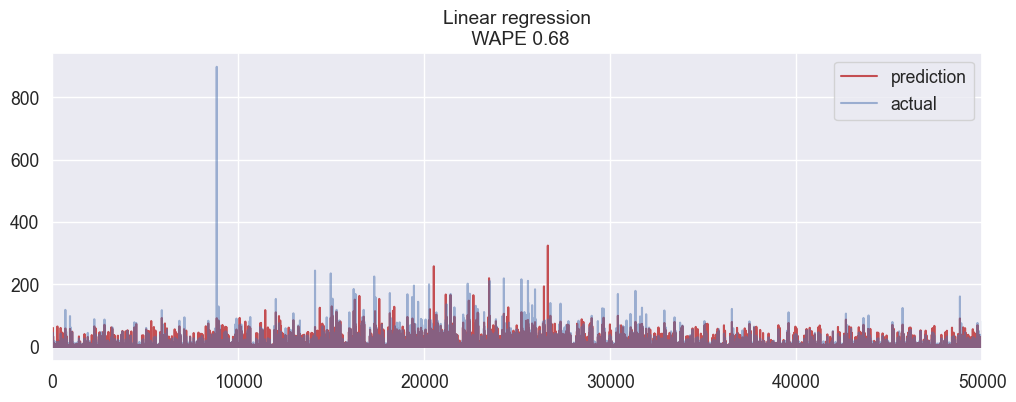

In [318]:
plt.figure(figsize=(12, 4))
plt.xlim(0, 50000)
plt.plot(lr_grid.best_estimator_.predict(X_val), 'r', label='prediction')
plt.plot(y_val.values, label='actual', alpha=0.5)
plt.legend(loc='best')
plt.title('Linear regression\n WAPE {}'.format(round(wape(y_val, lr_grid.best_estimator_.predict(X_val)), 2)))
plt.grid(True)

In [319]:
lgbm = LGBMRegressor(random_state=random_state)
parametrs = {'learning_rate': [0.1, 0.01, 0.001, 0.0001]}
lgbm_grid = GridSearchCV(lgbm, parametrs, scoring=score, cv=tscv)
lgbm_grid.fit(X_train, y_train)
wape(y_val, lgbm_grid.best_estimator_.predict(X_val))

0.40982039537660453

In [320]:
r2_score(y_val, lgbm_grid.best_estimator_.predict(X_val))

0.8072302268779586

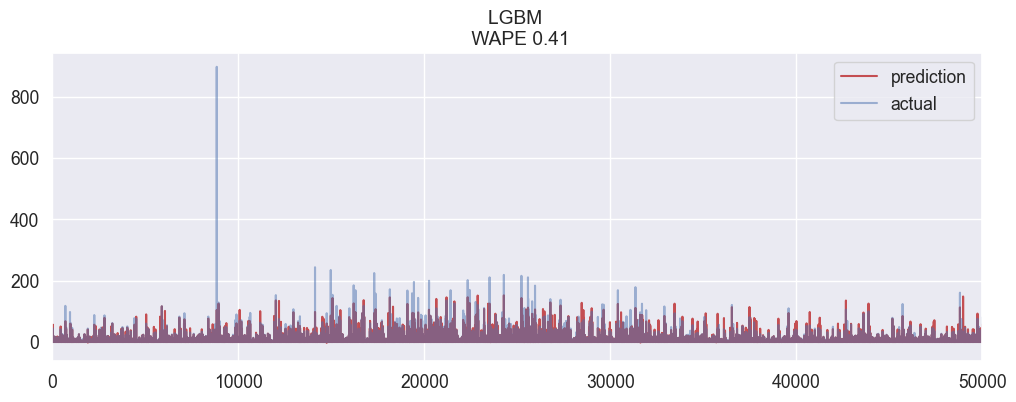

In [321]:
plt.figure(figsize=(12, 4))
plt.xlim(0, 50000)
plt.plot(lgbm_grid.best_estimator_.predict(X_val), 'r', label='prediction')
plt.plot(y_val.values, label='actual', alpha=0.5)
plt.legend(loc='best')
plt.title('LGBM \n WAPE {}'.format(round(wape(y_val, lgbm_grid.best_estimator_.predict(X_val)), 2)))
plt.grid(True)

- итого лучший результат метрики WAPE (0.41) показала модель градиентного бустинга
- посмотрим на важность признаков для модели
- проведем тестирование лучшей модели

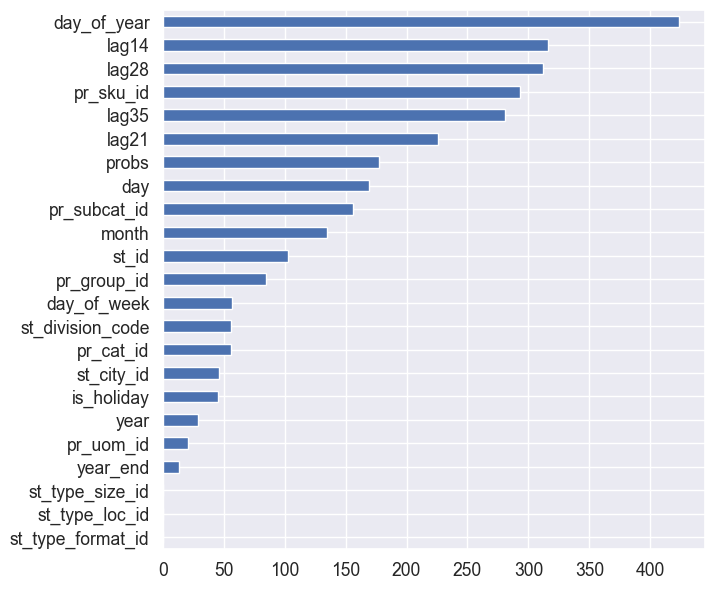

In [322]:
pd.DataFrame(data={'score': lgbm_grid.best_estimator_.feature_importances_}, 
                      index=X_train.columns).sort_values(by='score').plot(kind='barh', grid=True,
                                               figsize=(7, 7), legend=False);

In [323]:
#filename = 'finalized_model.sav'
#pickle.dump(lgbm_grid.best_estimator_, open(filename, 'wb'))

***5) Тестирование модели:***

- закодирую и нормализую тестовую часть признаков датасета
- проведу тестирование

In [324]:
X_test = test_data.drop('target', axis=1)
X_test_enc = pd.DataFrame(enc.transform(X_test[cats]), columns=new_columns, index=X_test[cats].index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[nums]), columns=col, index=X_test[nums].index)
X_test = pd.concat([X_test_enc, X_test_scaled], axis=1)

In [325]:
predictions = lgbm_grid.best_estimator_.predict(X_test)

In [326]:
submissions = sub[['st_id', 'pr_sku_id', 'date']]

In [327]:
submissions['target'] = predictions

In [328]:
submissions.to_csv('sales_submission.csv', index=False)

- Анализ важности признаков при использовании Shap values:

In [329]:
explainer = shap.Explainer(lgbm_grid.best_estimator_, X_train)
shap_values = explainer(X_test, check_additivity=False)

 99%|===================| 43334/43694 [00:23<00:00]        

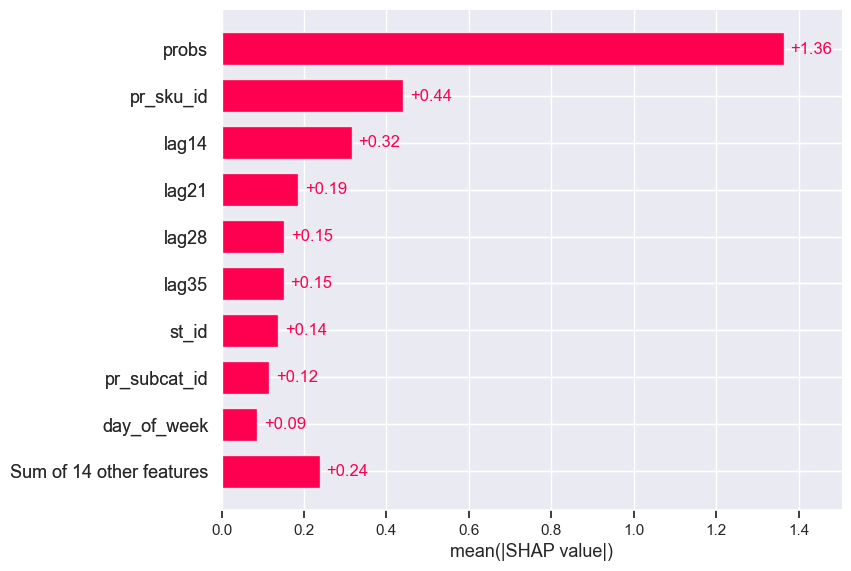

In [330]:
shap.plots.bar(shap_values)

***Выводы:***
- В ходе анализа исходного датасета было выявлено:
  - анализ временных рядов показал, что данный временной ряд относится к классу ТS(ряды, становящиеся стационарными после вычитания из них детерминированного тренда) и колебания целевой переменной укладываюся в интервал из 7 дней(эта информация необходима для расчета лагов)
  - проведенный тест Бреуша-Пагана показал, что в исходных данных присутствует гетероскедастичность
  - исходя из вышеизложенного мы имеем определенное количество выбросов значений целевой переменной(иногда превышающих ее значение более, чем в 100 раз)
  - причина части указанных выбросов была определена наличием предпраздничных и праздничных дней, оставшиеся хорошо сработавшими промоакциями.
- Целевая переменная количество данных в единицах
- Был воссоздан полный временной ряд со всеми уникальными сочетаниями магазин-товар
- В набор признаков для обучения модели были внесены признаки:
  - составляющие временной метки(дата, день в году и т.п.)
  - лаги целевой переменной, начиная с 14 дней(кратностью в 7 дней)
  - является ли день праздничным или предпраздничным(использовалась библиотека Holiday к ней в ручном режиме внесены предпраздничные дни)
  - также была создана модель логистической регрессии, которая выдала вероятности появления выбросов отдельно для тренировочного и тестового датасета, на основании этих данных был сформирован новый признак "вероятность появления выброса"(probs)
- Лучшей моделью была выбрана модель градиентного бустинга от lightgbm(показатель метрики WAPE - 0.41)
- Для анализа важности признаков SHAP values были получены с помощью метода Tree SHAP. На общем графике summary мы видим какие именно признаки оказали наибольшее влияние на предсказание модели(наибольший вклад внесли: сгенированный при помощи логистической регрессии признак probs, id товара, различные лаги и id магазина)